# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Данные находятся в трёх файлах:
 - *gold_recovery_train.csv* — обучающая выборка;
 - *gold_recovery_test.csv* — тестовая выборка;
 - *gold_recovery_full.csv* — исходные данные.
 
### Описание данных
Технологический процесс:
 - Rougher feed — исходное сырье
 - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
 - Xanthate — ксантогенат (промотер, или активатор флотации);
 - Sulphate — сульфат (на данном производстве сульфид натрия);
 - Depressant — депрессант (силикат натрия).
 - Rougher process (англ. «грубый процесс») — флотация
 - Rougher tails — отвальные хвосты
 - Float banks — флотационная установка
 - Cleaner process — очистка
 - Rougher Au — черновой концентрат золота
 - Final Au — финальный концентрат золота


Параметры этапов:
 - air amount — объём воздуха
 - fluid levels — уровень жидкости
 - feed size — размер гранул сырья
 - feed rate — скорость подачи

Наименование признаков должно быть такое: **[этап].[тип_параметра].[название_параметра]**

Пример: ***rougher.input.feed_ag***

Возможные значения для блока [этап]:
 - rougher — флотация
 - primary_cleaner — первичная очистка
 - secondary_cleaner — вторичная очистка
 - final — финальные характеристики

Возможные значения для блока [тип_параметра]:
 - input — параметры сырья
 - output — параметры продукта
 - state — параметры, характеризующие текущее состояние этапа
 - calculation — расчётные характеристики


*Данные индексируются датой и временем получения информации (признак* __date__*). Соседние по времени параметры часто похожи.*

### Оглавление
1. [Подготовка данных](#step_1)
2. [Анализ данных](#step_2)
3. [Модель](#step_3)

# 1. Подготовка данных
<a id="step_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
seed = 12345

### 1.1. Откройте файлы и изучите их.

In [4]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [5]:
train.shape, test.shape, full.shape

((16860, 87), (5856, 53), (22716, 87))

In [6]:
train.shape[0] / full.shape[0], test.shape[0] / full.shape[0]

(0.7422081352350766, 0.2577918647649234)

In [7]:
train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [8]:
test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [9]:
full.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [10]:
full.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
secondary_cleaner.output.tail_sol     2215
final.output.recovery                 1963
rougher.calculation.au_pb_ratio       1627
primary_cleaner.input.sulfate         1609
primary_cleaner.input.depressant      1546
dtype: int64

In [11]:
train.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

In [12]:
test.isna().sum().sort_values(ascending=False).head(10)

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

In [13]:
full.duplicated().sum()

0

Загрузили файлы, посмотрели как разбиты тренировочный и тестовый набор данных.

Пропусков очень много. Полных дублей нет.

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. 
Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

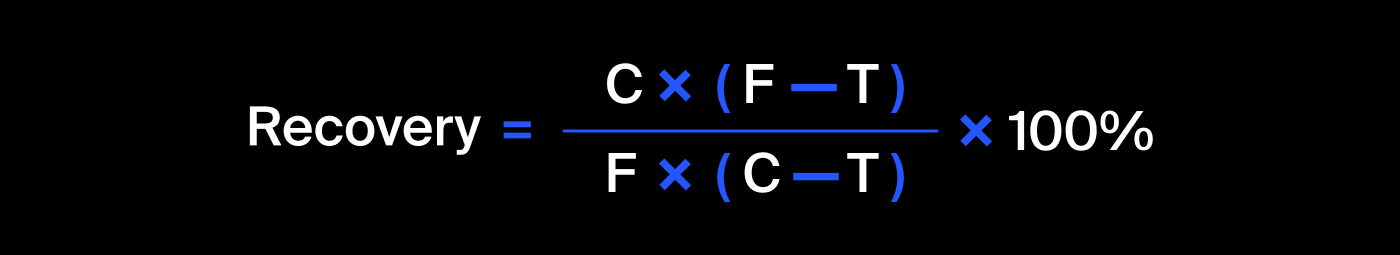

Эффективность обогащения рассчитывается по формуле выше, где:
 - C — доля золота в концентрате (concentrate_au) после (output) флотации/очистки (rougher);
 - F — доля золота в сырье/концентрате (feed_au) до (input) флотации/очистки (rougher);
 - T — доля золота в отвальных хвостах (tail_au) после (output) флотации/очистки (rougher).

In [14]:
recovery = train[['rougher.output.concentrate_au', 
                  'rougher.input.feed_au', 
                  'rougher.output.tail_au', 
                  'rougher.output.recovery']]

In [15]:
recovery = recovery.loc[recovery['rougher.input.feed_au'] > 0]

In [16]:
recovery = recovery.loc[recovery['rougher.output.tail_au'] != recovery['rougher.output.concentrate_au']]

In [17]:
recovery.isna().sum()

rougher.output.concentrate_au       0
rougher.input.feed_au               0
rougher.output.tail_au           1071
rougher.output.recovery          1331
dtype: int64

In [18]:
recovery = recovery.dropna()

In [19]:
recovery.describe()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
count,14287.000000,14287.000000,14287.000000,14287.000000
mean,19.399653,7.840161,1.761001,82.394201
std,3.858091,1.951916,0.727089,15.096808
min,0.000000,0.010000,0.020676,0.000000
25%,18.398075,6.582629,1.310274,79.818372
50%,19.942363,7.637921,1.745581,85.235997
75%,21.391148,9.052151,2.187862,90.131691
max,28.522811,13.126043,9.688980,100.000000


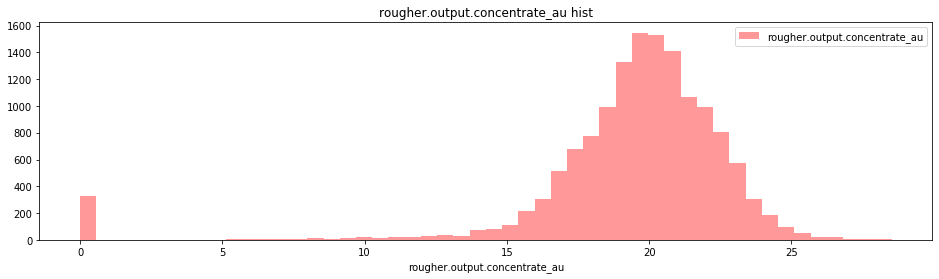

In [20]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(recovery['rougher.output.concentrate_au'].replace(np.nan, 0), label='rougher.output.concentrate_au', kde=False, color='r')
plt.title('rougher.output.concentrate_au hist')
plt.legend()
plt.show()

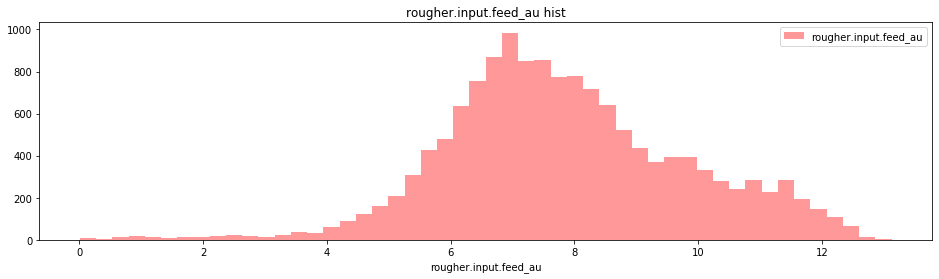

In [21]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(recovery['rougher.input.feed_au'].replace(np.nan, 0), label='rougher.input.feed_au', kde=False, color='r')
plt.title('rougher.input.feed_au hist')
plt.legend()
plt.show()

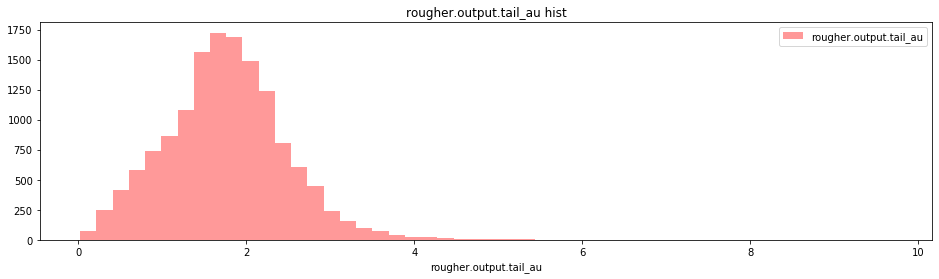

In [22]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(recovery['rougher.output.tail_au'].replace(np.nan, 0), label='rougher.output.tail_au', kde=False, color='r')
plt.title('rougher.output.tail_au hist')
plt.legend()
plt.show()

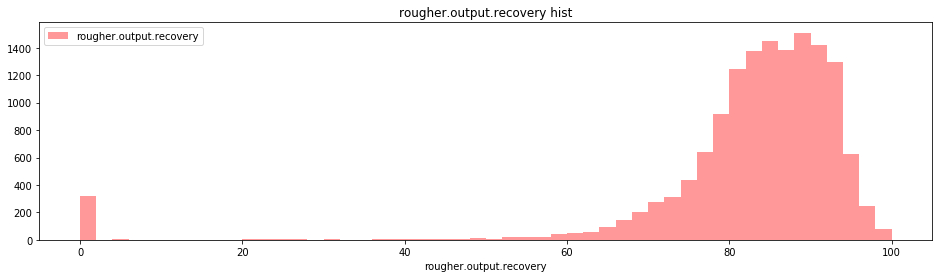

In [23]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(recovery['rougher.output.recovery'].replace(np.nan, 0), label='rougher.output.recovery', kde=False, color='r')
plt.title('rougher.output.recovery hist')
plt.legend()
plt.show()

In [24]:
C = recovery['rougher.output.concentrate_au']
F = recovery['rougher.input.feed_au']
T = recovery['rougher.output.tail_au']

In [25]:
recovery['calc'] = ((C * (F - T)) / (F * (C - T))) * 100

In [26]:
mean_absolute_error(recovery['rougher.output.recovery'], recovery['calc'])

9.444891926100695e-15

MAE = 9.444891926100695e-15. Наши расчеты практически не отличаются от предоставленных данных по эффективности обогащения.

Из тренировочной выборки мы исключили все кейсы приводящие к 0 в знаменателе и пропуски по непонятным причинам:
 - F должен быть больше 0
 - C не равно T

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [27]:
sorted(train.columns.difference(test.columns))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [28]:
sorted(train.columns)

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

В тестовой выборке отсутствуют расчетные признаки calculation и целевые признаки output.

### 1.4. Проведите предобработку данных.

In [29]:
rougher_features = [
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level'
]

rougher_target = ['rougher.output.recovery']

final_features = [
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size',
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_d_level',
    'secondary_cleaner.output.tail_ag',
    'secondary_cleaner.output.tail_au',
    'secondary_cleaner.output.tail_pb',
    'secondary_cleaner.output.tail_sol',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level'
]

final_target = ['final.output.recovery']

In [30]:
train = train.dropna(subset=rougher_target)
train = train.dropna(subset=final_target)

In [31]:
train.shape, test.shape, full.shape

((14149, 87), (5856, 53), (22716, 87))

In [32]:
train[rougher_features].isna().sum()

rougher.input.feed_ag                   0
rougher.input.feed_au                   0
rougher.input.feed_pb                 100
rougher.input.feed_rate                 8
rougher.input.feed_size               144
rougher.input.feed_sol                 78
rougher.input.floatbank10_sulfate      29
rougher.input.floatbank10_xanthate      8
rougher.input.floatbank11_sulfate      36
rougher.input.floatbank11_xanthate    428
rougher.state.floatbank10_a_air         1
rougher.state.floatbank10_a_level       1
rougher.state.floatbank10_b_air         1
rougher.state.floatbank10_b_level       1
rougher.state.floatbank10_c_air         1
rougher.state.floatbank10_c_level       1
rougher.state.floatbank10_d_air         0
rougher.state.floatbank10_d_level       0
rougher.state.floatbank10_e_air       436
rougher.state.floatbank10_e_level       0
rougher.state.floatbank10_f_air         0
rougher.state.floatbank10_f_level       0
dtype: int64

In [33]:
train[final_features].isna().sum()

primary_cleaner.input.depressant                32
primary_cleaner.input.feed_size                  0
primary_cleaner.input.sulfate                   20
primary_cleaner.input.xanthate                 100
primary_cleaner.state.floatbank8_a_air           4
primary_cleaner.state.floatbank8_a_level         1
primary_cleaner.state.floatbank8_b_air           4
primary_cleaner.state.floatbank8_b_level         1
primary_cleaner.state.floatbank8_c_air           2
primary_cleaner.state.floatbank8_c_level         1
primary_cleaner.state.floatbank8_d_air           3
primary_cleaner.state.floatbank8_d_level         1
secondary_cleaner.output.tail_ag                 2
secondary_cleaner.output.tail_au                 0
secondary_cleaner.output.tail_pb                10
secondary_cleaner.output.tail_sol             1605
secondary_cleaner.state.floatbank2_a_air       217
secondary_cleaner.state.floatbank2_a_level       1
secondary_cleaner.state.floatbank2_b_air        21
secondary_cleaner.state.floatba

In [34]:
train = train.set_index('date')
full = full.set_index('date')
test = test.set_index('date')

In [35]:
full_ffill = full.fillna(method='ffill')

In [36]:
train[rougher_features] = full_ffill.loc[train.index, rougher_features]
train[final_features] = full_ffill.loc[train.index, final_features]

In [37]:
train_rougher = train.replace({rougher_target[0]: {0: np.nan}}).dropna(subset=rougher_target)
train_final = train.replace({final_target[0]: {0: np.nan}}).dropna(subset=final_target)

train_rougher = train_rougher[rougher_features].join(train_rougher[rougher_target])
train_final = train_final[final_features].join(train_final[final_target])

In [38]:
test[rougher_features] = full_ffill.loc[test.index, rougher_features]
test[final_features] = full_ffill.loc[test.index, final_features]

test_rougher = test[rougher_features].join(full[rougher_target])
test_final = test[final_features].join(full[final_target])

test_rougher = test_rougher.replace({rougher_target[0]: {0: np.nan}}).dropna(subset=rougher_target)
test_final = test_final.replace({rougher_target[0]: {0: np.nan}}).dropna(subset=final_target)

In [39]:
train_rougher.isna().sum()

rougher.input.feed_ag                 0
rougher.input.feed_au                 0
rougher.input.feed_pb                 0
rougher.input.feed_rate               0
rougher.input.feed_size               0
rougher.input.feed_sol                0
rougher.input.floatbank10_sulfate     0
rougher.input.floatbank10_xanthate    0
rougher.input.floatbank11_sulfate     0
rougher.input.floatbank11_xanthate    0
rougher.state.floatbank10_a_air       0
rougher.state.floatbank10_a_level     0
rougher.state.floatbank10_b_air       0
rougher.state.floatbank10_b_level     0
rougher.state.floatbank10_c_air       0
rougher.state.floatbank10_c_level     0
rougher.state.floatbank10_d_air       0
rougher.state.floatbank10_d_level     0
rougher.state.floatbank10_e_air       0
rougher.state.floatbank10_e_level     0
rougher.state.floatbank10_f_air       0
rougher.state.floatbank10_f_level     0
rougher.output.recovery               0
dtype: int64

In [40]:
train_final.isna().sum()

primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
secondary_cleaner.output.tail_ag              0
secondary_cleaner.output.tail_au              0
secondary_cleaner.output.tail_pb              0
secondary_cleaner.output.tail_sol             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air

In [41]:
test_rougher.isna().sum()

rougher.input.feed_ag                 0
rougher.input.feed_au                 0
rougher.input.feed_pb                 0
rougher.input.feed_rate               0
rougher.input.feed_size               0
rougher.input.feed_sol                0
rougher.input.floatbank10_sulfate     0
rougher.input.floatbank10_xanthate    0
rougher.input.floatbank11_sulfate     0
rougher.input.floatbank11_xanthate    0
rougher.state.floatbank10_a_air       0
rougher.state.floatbank10_a_level     0
rougher.state.floatbank10_b_air       0
rougher.state.floatbank10_b_level     0
rougher.state.floatbank10_c_air       0
rougher.state.floatbank10_c_level     0
rougher.state.floatbank10_d_air       0
rougher.state.floatbank10_d_level     0
rougher.state.floatbank10_e_air       0
rougher.state.floatbank10_e_level     0
rougher.state.floatbank10_f_air       0
rougher.state.floatbank10_f_level     0
rougher.output.recovery               0
dtype: int64

In [42]:
test_final.isna().sum()

primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
secondary_cleaner.output.tail_ag              0
secondary_cleaner.output.tail_au              0
secondary_cleaner.output.tail_pb              0
secondary_cleaner.output.tail_sol             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air

- Удалили из обучающего набора строки с пропусками целевого признака.
- Сделали индексом дату со временем.
- Заполнили в общем наборе методом ffill.
- Перенесли заполненные данные в тренировочный набор.
- Разбили на 2 тренировочных набора rougher и final

### Вывод

Загрузили 3 исходных файла.
Тренировочный набор и тестовый разделены в соотношении 74:26.
У нас 87 признаков. Есть пропуски во многих столбцах и во всех датафреймах.

Из тренировочного набора удалили строки с пропуском целевого признака, пропуски остальных признаков заполнили методом ffill значением из ближайшей строки.

# 2. Анализ данных
<a id="step_2"></a>

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 
Опишите выводы.

In [43]:
au_cols = [
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au'
]

ag_cols = [
    'rougher.input.feed_ag',
    'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag'
]

pb_cols = [
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb'
]

In [44]:
def steps(col):
    value = full[col].replace(0, np.nan).dropna()
    step = ['.'.join(col.split('.')[:2]) for x in range(len(value))]
    
    return step, value

In [45]:
au = pd.DataFrame(data={'step':[], 'value':[]})

for col in au_cols:
    s, v = steps(col)
    au = pd.concat([au, pd.DataFrame(data={'step':s, 'value':v})])

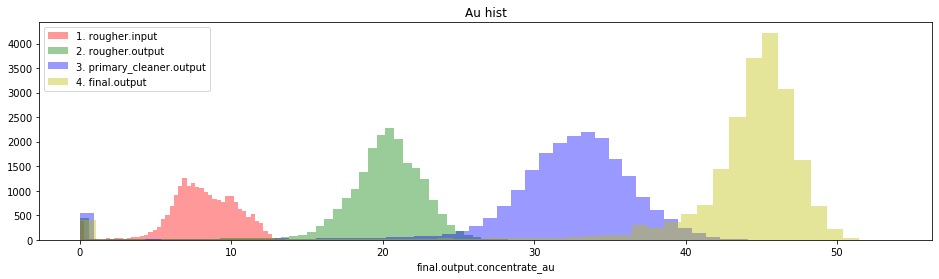

In [46]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(full['rougher.input.feed_au'].replace(0, np.nan).dropna(), label='1. rougher.input', kde=False, color='r')
sns.distplot(full['rougher.output.concentrate_au'].replace(0, np.nan).dropna(), label='2. rougher.output', kde=False, color='g')
sns.distplot(full['primary_cleaner.output.concentrate_au'].replace(0, np.nan).dropna(), label='3. primary_cleaner.output', kde=False, color='b')
sns.distplot(full['final.output.concentrate_au'].replace(0, np.nan).dropna(), label='4. final.output', kde=False, color='y')
plt.title('Au hist')
plt.legend()
plt.show()

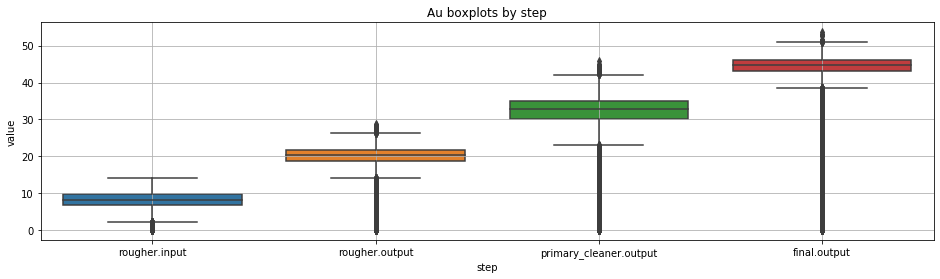

In [47]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=au['step'], y=au['value'])
plt.title('Au boxplots by step')
plt.grid()
plt.show()

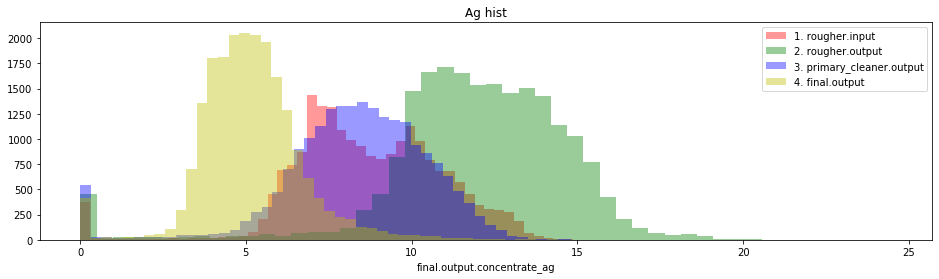

In [48]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(full['rougher.input.feed_ag'].replace(0, np.nan).dropna(), label='1. rougher.input', kde=False, color='r')
sns.distplot(full['rougher.output.concentrate_ag'].replace(0, np.nan).dropna(), label='2. rougher.output', kde=False, color='g')
sns.distplot(full['primary_cleaner.output.concentrate_ag'].replace(0, np.nan).dropna(), label='3. primary_cleaner.output', kde=False, color='b')
sns.distplot(full['final.output.concentrate_ag'].replace(0, np.nan).dropna(), label='4. final.output', kde=False, color='y')
plt.title('Ag hist')
plt.legend()
plt.show()

In [49]:
ag = pd.DataFrame(data={'step':[], 'value':[]})

for col in ag_cols:
    s, v = steps(col)
    ag = pd.concat([ag, pd.DataFrame(data={'step':s, 'value':v})])

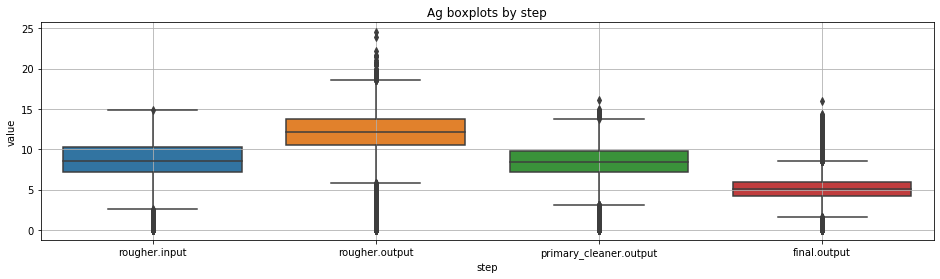

In [50]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=ag['step'], y=ag['value'])
plt.title('Ag boxplots by step')
plt.grid()
plt.show()

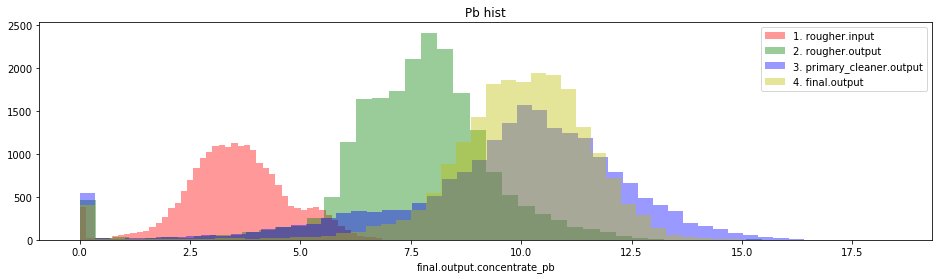

In [51]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(full['rougher.input.feed_pb'].replace(0, np.nan).dropna(), label='1. rougher.input', kde=False, color='r')
sns.distplot(full['rougher.output.concentrate_pb'].replace(0, np.nan).dropna(), label='2. rougher.output', kde=False, color='g')
sns.distplot(full['primary_cleaner.output.concentrate_pb'].replace(0, np.nan).dropna(), label='3. primary_cleaner.output', kde=False, color='b')
sns.distplot(full['final.output.concentrate_pb'].replace(0, np.nan).dropna(), label='4. final.output', kde=False, color='y')
plt.title('Pb hist')
plt.legend()
plt.show()

In [52]:
pb = pd.DataFrame(data={'step':[], 'value':[]})

for col in pb_cols:
    s, v = steps(col)
    pb = pd.concat([pb, pd.DataFrame(data={'step':s, 'value':v})])

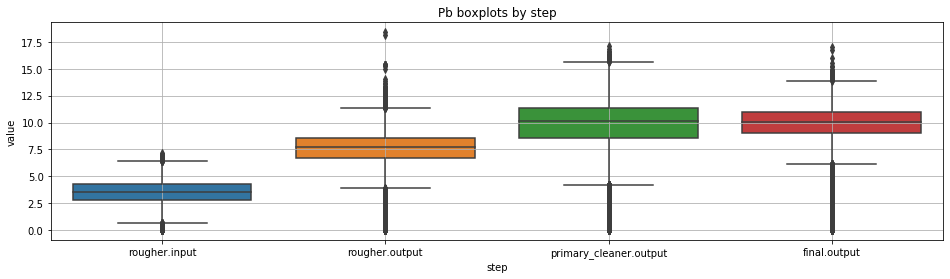

In [53]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=pb['step'], y=pb['value'])
plt.title('Pb boxplots by step')
plt.grid()
plt.show()

### Вывод

Концентрация золота на каждом этапе увеличивается, свинца так же увеличивается, а вот серебра после двух этапов очистки становится меньше

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. 
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [54]:
train['rougher.input.feed_size']

date
2016-01-15 00:00:00     55.486599
2016-01-15 01:00:00     57.278666
2016-01-15 02:00:00     57.510649
2016-01-15 03:00:00     57.792734
2016-01-15 04:00:00     56.047189
                          ...    
2018-08-18 06:59:59     85.718304
2018-08-18 07:59:59    119.499241
2018-08-18 08:59:59    122.262690
2018-08-18 09:59:59    123.742430
2018-08-18 10:59:59     94.544358
Name: rougher.input.feed_size, Length: 14149, dtype: float64

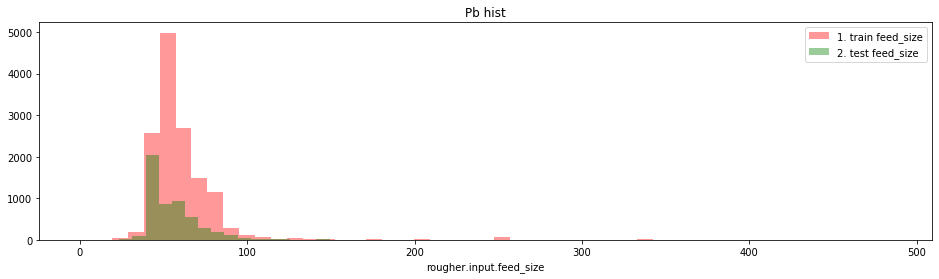

In [55]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(train_rougher['rougher.input.feed_size'], label='1. train feed_size', kde=False, color='r')
sns.distplot(test_rougher['rougher.input.feed_size'], label='2. test feed_size', kde=False, color='g')
plt.title('Pb hist')
plt.legend()
plt.show()

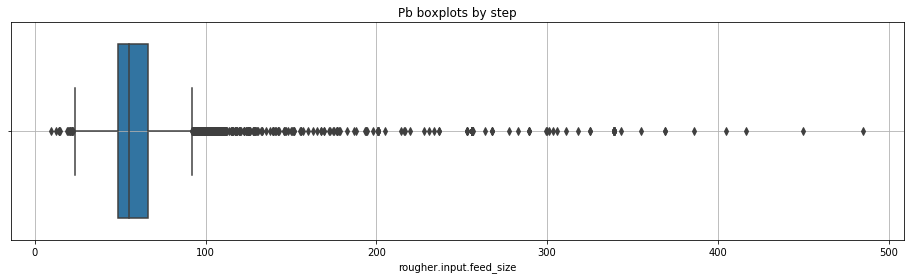

In [56]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=train_rougher['rougher.input.feed_size'])
plt.title('Pb boxplots by step')
plt.grid()
plt.show()

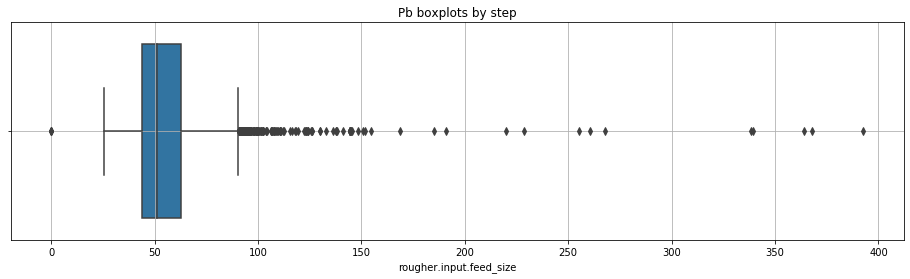

In [57]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=test_rougher['rougher.input.feed_size'])
plt.title('Pb boxplots by step')
plt.grid()
plt.show()

### Вывод

Размеры гранул сырья в тестовой и тренировочной выборка распределы примерно одинаково (визуально, можно было бы для наглядности проверить гипотезу проведя t-тест).

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
- Заметили аномальные значения в суммарном распределении или нет? 
- Если они есть, стоит ли их удалять из обеих выборок? 
- Опишите выводы и удалите аномалии.

In [58]:
rougher_input = train_rougher['rougher.input.feed_au'] + \
                train_rougher['rougher.input.feed_ag'] + \
                train_rougher['rougher.input.feed_pb']

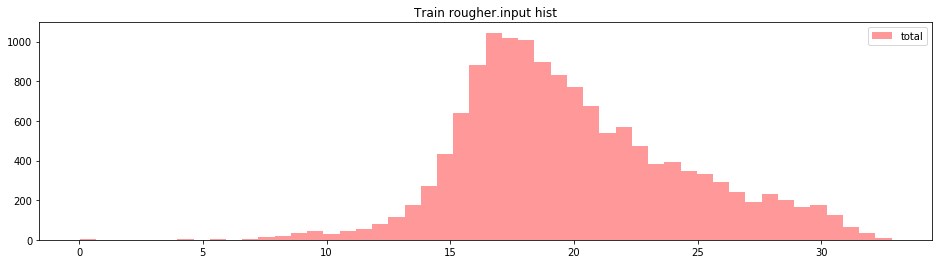

In [59]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(rougher_input, label='total', kde=False, color='r')
plt.title('Train rougher.input hist')
plt.legend()
plt.show()

In [60]:
final_output = train_final['secondary_cleaner.output.tail_au'] + \
               train_final['secondary_cleaner.output.tail_ag'] + \
               train_final['secondary_cleaner.output.tail_pb']

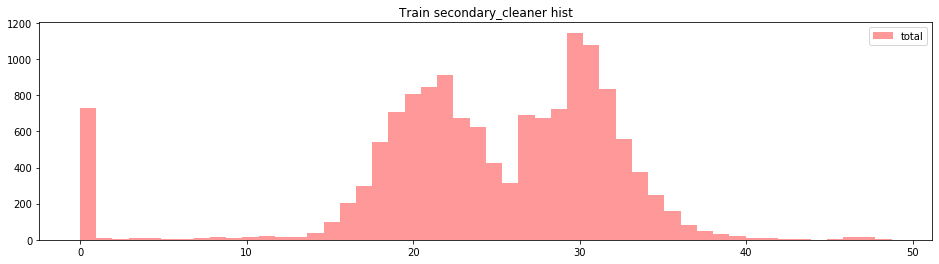

In [61]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(final_output, label='total', kde=False, color='r')
plt.title('Train secondary_cleaner hist')
plt.legend()
plt.show()

In [62]:
train_final[[
        'secondary_cleaner.output.tail_au', 
        'secondary_cleaner.output.tail_ag', 
        'secondary_cleaner.output.tail_pb'
]].replace(0, np.nan).isna().sum()

secondary_cleaner.output.tail_au    727
secondary_cleaner.output.tail_ag    727
secondary_cleaner.output.tail_pb    727
dtype: int64

In [63]:
train_final = (
    train_final
    .replace(0, np.nan)
    .dropna(subset=[
        'secondary_cleaner.output.tail_au', 
        'secondary_cleaner.output.tail_ag', 
        'secondary_cleaner.output.tail_pb'
    ], how='all')
    .replace(np.nan, 0)
)

In [64]:
train_final[[
        'secondary_cleaner.output.tail_au', 
        'secondary_cleaner.output.tail_ag', 
        'secondary_cleaner.output.tail_pb'
]].replace(0, np.nan).isna().sum()

secondary_cleaner.output.tail_au    0
secondary_cleaner.output.tail_ag    0
secondary_cleaner.output.tail_pb    0
dtype: int64

In [65]:
train_final[train_final['secondary_cleaner.output.tail_ag'] == 0]

,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.sulfate,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [66]:
final_output = train_final['secondary_cleaner.output.tail_au'] + \
               train_final['secondary_cleaner.output.tail_ag'] + \
               train_final['secondary_cleaner.output.tail_pb']

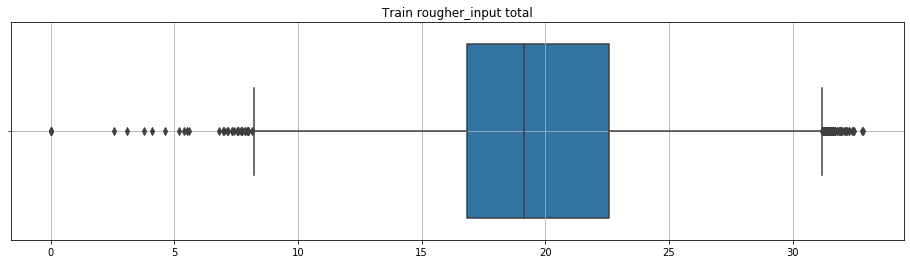

In [67]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=rougher_input)
plt.title('Train rougher_input total')
plt.grid()
plt.show()

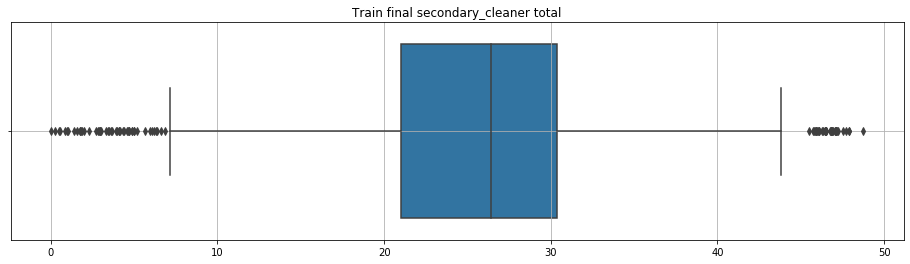

In [68]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=final_output)
plt.title('Train final secondary_cleaner total')
plt.grid()
plt.show()

In [69]:
rougher_q1 = rougher_input.quantile(0.25)
rougher_q3 = rougher_input.quantile(0.75)
rougher_iqr = rougher_q3 - rougher_q1
(rougher_q3 - 3*rougher_iqr, rougher_q3 + 3*rougher_iqr)

(5.3332041899864215, 39.80589391057589)

In [70]:
rougher_input[(rougher_input < (rougher_q3 - 3*rougher_iqr)) & (rougher_input > (rougher_q3 + 3*rougher_iqr))]

Series([], dtype: float64)

In [71]:
final_q1 = final_output.quantile(0.25)
final_q3 = final_output.quantile(0.75)
final_iqr = final_q3 - final_q1
(final_q3 - 3*final_iqr, final_q3 + 3*final_iqr)

(2.337888748046563, 58.4178863748423)

In [72]:
final_output[(final_output < (final_q3 - 3*final_iqr)) & (final_output > (final_q3 + 3*final_iqr))]

Series([], dtype: float64)

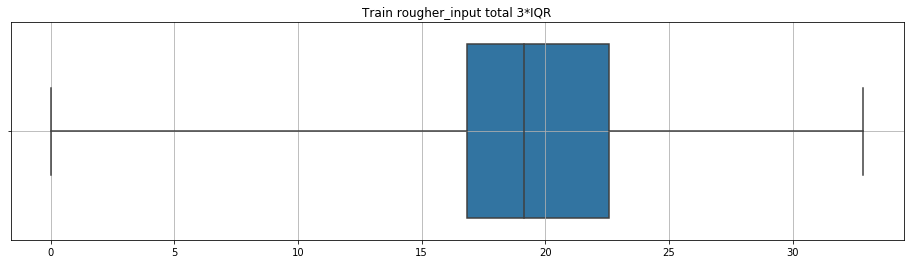

In [73]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=rougher_input, whis=3)
plt.title('Train rougher_input total 3*IQR')
plt.grid()
plt.show()

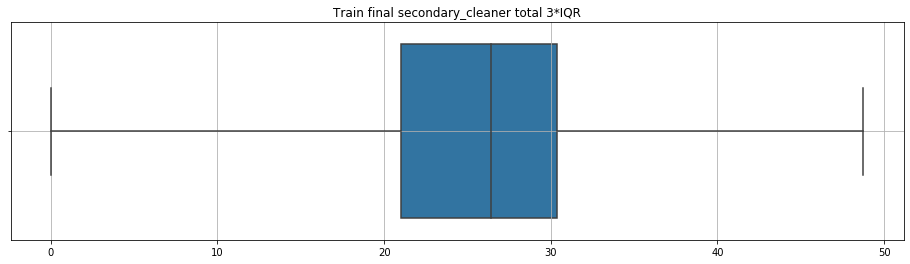

In [74]:
fig = plt.figure(figsize=(16,4))
sns.boxplot(x=final_output, whis=3)
plt.title('Train final secondary_cleaner total 3*IQR')
plt.grid()
plt.show()

### Вывод

Часть пропусков и нолей у нас ушла когда мы занимались предобработкой данных, но часть все еще оставалась, мы её так же удалили из обучающей выборки для этапа очистки.

Так же проверили выбросы, взяв интервал 3 межквартильных размаха.  И по расчетам и по ящику с усами грубых выбросов не нашлось.

# 3. Модель
<a id="step_3"></a>

### 3.1. Напишите функцию для вычисления итоговой sMAPE.


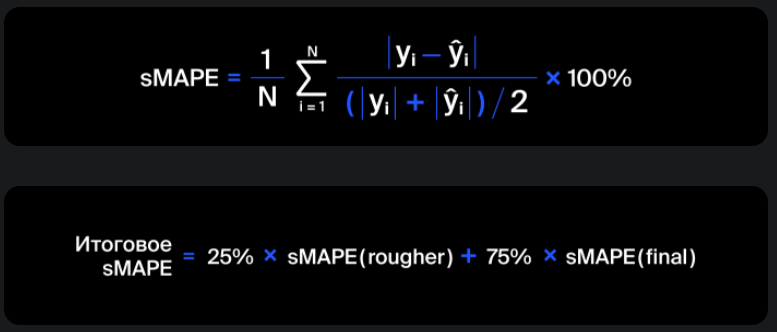

In [75]:
def sMAPE(target, predictions):
    return np.mean((100 * np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2)))

In [76]:
def total_sMAPE(rougher_sMAPE, final_sMAPE):
    return 0.25 * rougher_sMAPE + 0.75 * final_sMAPE

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. 
- Выберите лучшую модель и проверьте её на тестовой выборке. 
- Опишите выводы.

In [77]:
smape_score = make_scorer(sMAPE, greater_is_better=False)
# smape_score = make_scorer(sMAPE)

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=seed)

#### Линейная регрессия

In [78]:
model_l_rougher = LinearRegression()
model_l_final = LinearRegression()

In [79]:
rougher_l_cv = cross_val_score(
    model_l_rougher, 
    train_rougher[rougher_features].to_numpy(), 
    train_rougher[rougher_target].to_numpy(), 
    cv=cv,
    scoring = smape_score,
    n_jobs = -1
).mean()

rougher_l_cv

-5.110986392151724

In [80]:
final_l_cv = cross_val_score(
    model_l_final, 
    train_final[final_features].to_numpy(), 
    train_final[final_target].to_numpy(), 
    cv=cv,
    scoring = smape_score,
    n_jobs = -1
).mean()

final_l_cv

-7.28879741993409

In [81]:
total_l = total_sMAPE(rougher_l_cv, final_l_cv)

In [82]:
print('--LinearRegression--')
print(f'Rougher sMAPE {rougher_l_cv:.2f}%')
print(f'Final sMAPE {final_l_cv:.2f}%')
print(f'Total sMAPE {total_l:.2f}%')

--LinearRegression--
Rougher sMAPE -5.11%
Final sMAPE -7.29%
Total sMAPE -6.74%


#### Дерево решений

In [83]:
# model_r_rougher = RandomForestRegressor(random_state=seed, n_estimators=7, max_depth=1)
# model_r_final = RandomForestRegressor(random_state=seed, n_estimators=3, max_depth=6)

In [84]:
rougher_r_cv = -200
best_depth = 0
best_est = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model_r_rougher = RandomForestRegressor(random_state=seed, n_estimators=est, max_depth=depth)
        cross_val = cross_val_score(
            model_r_rougher, 
            train_rougher[rougher_features].to_numpy(), 
            train_rougher[rougher_target].to_numpy(),
            cv=cv,
            scoring =  smape_score,
            n_jobs = -1
        ).mean()
        
        if cross_val > rougher_r_cv:
            rougher_r_cv = cross_val
            best_depth = depth
            best_est = est

print(f'Rougher est: {best_est}, depth: {best_depth}, sMAPE: {rougher_r_cv}')

Rougher est: 7, depth: 1, sMAPE: -7.967900717392763


In [85]:
final_r_cv = -200
best_depth = 0
best_est = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model_r_final = RandomForestRegressor(random_state=seed, n_estimators=est, max_depth=depth)
        cross_val = cross_val_score(
            model_r_final, 
            train_final[final_features].to_numpy(), 
            train_final[final_target].to_numpy(), 
            cv=cv,
            scoring = smape_score,
            n_jobs = -1
        ).mean()
        
        if cross_val > final_r_cv:
            final_r_cv = cross_val
            best_depth = depth
            best_est = est

print(f'Final est: {best_est}, depth: {best_depth}, sMAPE: {final_r_cv}')

Final est: 4, depth: 1, sMAPE: -10.955663023297166


In [86]:
total_r = total_sMAPE(rougher_r_cv, final_r_cv)

In [87]:
print('--RandomForestRegressor--')
print(f'Rougher sMAPE {rougher_r_cv:.2f}%')
print(f'Final sMAPE {final_r_cv:.2f}%')
print(f'Total sMAPE {total_r:.2f}%')

--RandomForestRegressor--
Rougher sMAPE -7.97%
Final sMAPE -10.96%
Total sMAPE -10.21%


### Тестовая выборка

In [88]:
# model_rougher = RandomForestRegressor(random_state=seed, n_estimators=7, max_depth=1)
# model_final = RandomForestRegressor(random_state=seed, n_estimators=4, max_depth=1)
model_rougher = LinearRegression()
model_final = LinearRegression()

In [89]:
model_rougher.fit(train_rougher[rougher_features].to_numpy(), train_rougher[rougher_target].to_numpy())
rougher_predictions = model_rougher.predict(test_rougher[rougher_features].to_numpy())
test_rougher_sMAPE = sMAPE(test_rougher[rougher_target].to_numpy(), rougher_predictions)
test_rougher_sMAPE

4.666498987924781

In [90]:
model_final.fit(train_final[final_features].to_numpy(), train_final[final_target].to_numpy())
final_predictions = model_final.predict(test_final[final_features].to_numpy())
test_final_sMAPE = sMAPE(test_final[final_target].to_numpy(), final_predictions)
test_final_sMAPE

9.534660511296599

In [91]:
total_test = total_sMAPE(test_rougher_sMAPE, test_final_sMAPE)

In [92]:
print('--LinearRegression Test--')
print(f'Test Rougher sMAPE {test_rougher_sMAPE:.2f}%')
print(f'Test Final sMAPE {test_final_sMAPE:.2f}%')
print(f'Test Total sMAPE {total_test:.2f}%')

--LinearRegression Test--
Test Rougher sMAPE 4.67%
Test Final sMAPE 9.53%
Test Total sMAPE 8.32%


### Проверка на адекватность

In [93]:
median_rougher_predictions = test_rougher[rougher_target] * 0 + test_rougher[rougher_target].median()
median_test_rougher_sMAPE = sMAPE(test_rougher[rougher_target].to_numpy(), median_rougher_predictions.to_numpy())
median_test_rougher_sMAPE

4.555992250475486

In [94]:
median_final_predictions = test_final[final_target] * 0 + test_final[final_target].median()
median_test_final_sMAPE = sMAPE(test_final[final_target].to_numpy(), median_final_predictions.to_numpy())
median_test_final_sMAPE

10.100951768870399

In [95]:
median_total_test = total_sMAPE(median_test_rougher_sMAPE, median_test_final_sMAPE)

In [96]:
print('--Median Test--')
print(f'Median Test Rougher sMAPE {median_test_rougher_sMAPE:.2f}%')
print(f'Median Test Final sMAPE {median_test_final_sMAPE:.2f}%')
print(f'Median Test Total sMAPE {median_total_test:.2f}%')

--Median Test--
Median Test Rougher sMAPE 4.56%
Median Test Final sMAPE 10.10%
Median Test Total sMAPE 8.71%


### Вывод

На тестовой выборке мы получилли итоговый sMAPE больше чем на тренировочной выборке: 8.32% (против -6.74% на тренировочной выборке). Лучший результат показала модель линейной регрессии.

Линейная регрессия на тестовой выборке показала итоговый sMAPE очень похожий на константную модель с медианой.